# L-BFGS and Vector-free L-BFGS demonstration

In [1]:
# !git clone https://github.com/agatheminaro/CloudComputing__L-BFGS.git

In [2]:
%cd CloudComputing__L-BFGS/

[Errno 2] No such file or directory: 'CloudComputing__L-BFGS/'
/home/onyxia/work/CloudComputing__L-BFGS


In [4]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 4.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 7.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 3.5 MB/s eta 0:00:00a 0:00:01


In [5]:
import numpy as np
import lbfgs
import utils
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import check_grad
import matplotlib.pyplot as plt
from time import time
import torch

## Check of the convergence 

We check that the algorithms implemented for L-BFGS and Vector-free L-BFGS (VL-BFGS) converges correctly by comparing them to the corresponding algorithm of scipy.

#### Simulate data

In [6]:
# Parameters
d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Ground truth coefficients of the model
coefs = (-1) ** idx * np.exp(-idx / 10.)

In [7]:
_A, _b = utils.simulate_data_numpy(coefs, n, std=1., corr=0.8, log_reg=False)

#### Check of the gradient computation

In [8]:
check_grad(utils.loss_linreg_numpy, utils.grad_linreg_numpy, np.random.randn(d), _A, _b, lbda)

1.4594121287948296e-06

#### Optimization for linear regression

In [9]:
f = utils.loss_linreg_numpy
f_grad = utils.grad_linreg_numpy

x_init = np.zeros(d)

In [10]:
print("---- Scipy ----")
t0 = time()
x_min_scipy, f_min_scipy, _ = fmin_l_bfgs_b(f, x_init, f_grad, args=(_A, _b, lbda), pgtol=1e-30, factr=1e-30, maxiter=100)
print("Computation time: ", time()-t0)

print("\n---- L-BFGS ----")
lbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, torch=False)
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS ----")
vlbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, torch=False)
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_vlbfgs)

---- Scipy ----
Computation time:  1.6033172607421875

---- L-BFGS ----
Computation time:  7.2174882888793945

---- VL-BFGS ----
Computation time:  6.285403251647949


In [11]:
print("----- Results: -----")
print("Scipy minimum: ", round(f_min_scipy, 5))
print("L-BFGS minimum: ", round(f_min_lbfgs[-1], 5))
print("VL-BFGS minimum: ", round(f_min_vlbfgs[-1], 5))

----- Results: -----
Scipy minimum:  0.56815
L-BFGS minimum:  0.56815
VL-BFGS minimum:  0.56815


## Comparison of efficiency

### Use of GPUs

In [12]:
# Parameters
d = 4000
n = 500000
coefs = torch.randn(d)
_A, _b = utils.simulate_data_torch(coefs, n)

lbda = 1. / n ** (0.5)

In [13]:
f = utils.loss_linreg_torch
f_grad = utils.grad_linreg_torch

x_init = torch.zeros_like(coefs)

In [14]:
print("\n---- L-BFGS ----")
lbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, torch=True, device='cuda:0')
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS ----")
vlbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, torch=True, device="cuda:0")
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
print("Computation time: ", time_vlbfgs)


---- L-BFGS ----
Computation time:  78.20385766029358

---- VL-BFGS ----
Computation time:  65.77520847320557


In [15]:
print("----- Results: -----")
print("L-BFGS minimum: ", round(f_min_lbfgs[-1], 5))
print("VL-BFGS minimum: ", round(f_min_vlbfgs[-1], 5))

----- Results: -----
L-BFGS minimum:  3.39899
VL-BFGS minimum:  3.39899


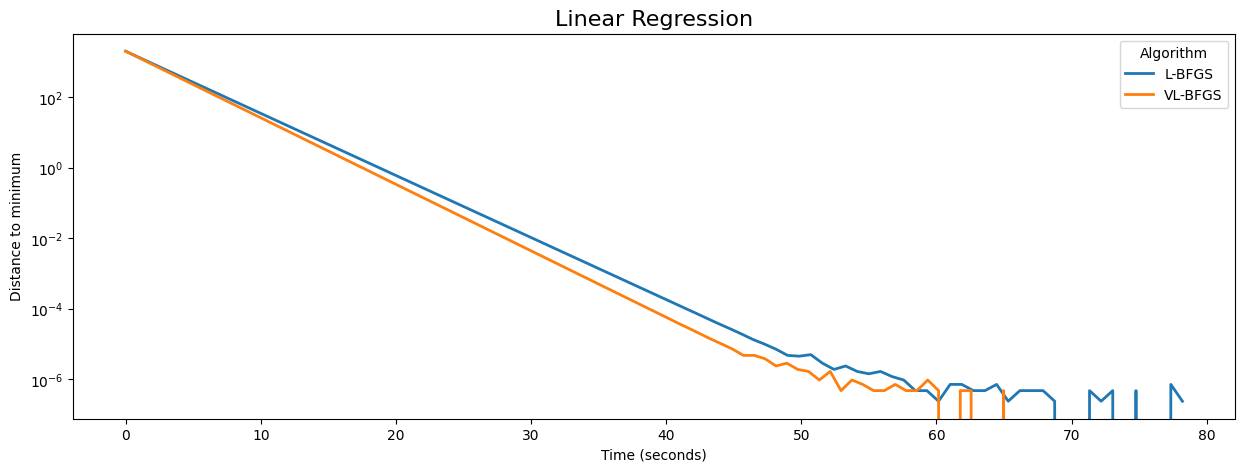

In [16]:
f_min = min(f_min_lbfgs[-1], f_min_vlbfgs[-1])

plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, time_lbfgs, len(f_min_lbfgs)), np.array(f_min_lbfgs) - f_min, lw=2, label='L-BFGS')
plt.semilogy(np.linspace(0, time_vlbfgs, len(f_min_vlbfgs)), np.array(f_min_vlbfgs) - f_min, lw=2, label='VL-BFGS')
plt.yscale('log')
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()

### Increase of features

In [17]:
import utils
import lbfgs
import torch
from tqdm import tqdm

In [18]:
f = utils.loss_linreg_torch
f_grad = utils.grad_linreg_torch

In [19]:
d_list = np.arange(0, 5001, 500)
n = 500000
lbda = 1. / n ** (0.5)

times_lbfgs = []
times_vlbfgs = []

for d in tqdm(d_list[1:]):
    coefs = torch.randn(d)
    _A, _b = utils.simulate_data_torch(coefs, n)

    x_init = torch.zeros_like(coefs)

    lbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=100, torch=True, device='cuda:0')
    _, _, time  = lbfgs_optimizer.fit(x_init, _A, _b, lbda)
    times_lbfgs.append(time)

    vlbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=100, torch=True, device="cuda:0")
    _, _, time = vlbfgs_optimizer.fit(x_init, _A, _b, lbda)
    times_vlbfgs.append(time)

    del _A
    del _b
    del x_init
    del coefs


100%|██████████| 10/10 [19:45<00:00, 118.53s/it]


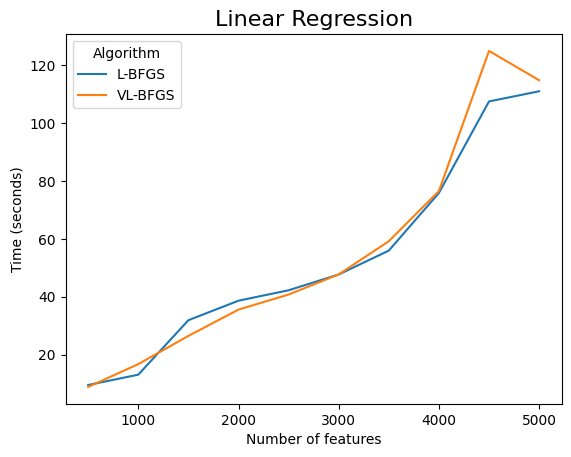

In [20]:
plt.plot(d_list[1:], times_lbfgs, label="L-BFGS")
plt.plot(d_list[1:], times_vlbfgs, label="VL-BFGS")
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Number of features')
plt.ylabel('Time (seconds)')
plt.show()

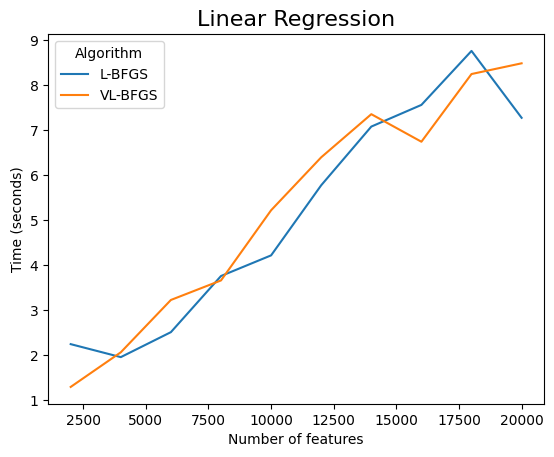

In [9]:
plt.plot(d_list[1:], times_lbfgs, label="L-BFGS")
plt.plot(d_list[1:], times_vlbfgs, label="VL-BFGS")
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Number of features')
plt.ylabel('Time (seconds)')
plt.show()

## Optimization on real data

### Get Data

In [21]:
import numpy as np
import torch

We choose to take the Million Song Dataset taken from the UCI dataset website.

In [29]:
print("Loading data...")
with open('data/YearPredictionMSD.txt', 'r') as f:
    # read contents into NumPy array
    data = np.loadtxt(f, delimiter=',')
y = data[:,0].astype(int)
X = data[:,1:]
del data
print("Data loaded.")

print("Change to tensor...")
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int)
print("Data changed.")

d = X.shape[1]
n = X.shape[0]

print("Number of features: ", d)
print("Number of samples: ", n)

Loading data...
Data loaded.
Change to tensor...
Data changed.
Number of features:  90
Number of samples:  515345


### Optimization

In [35]:
import importlib

In [41]:
lbda = 1. / n ** (0.5)

f = utils.loss_linreg_torch
f_grad = utils.grad_linreg_torch

x_init = torch.rand(d)

In [43]:
print("\n---- L-BFGS CPU ----")
lbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=10000, torch=True, device='cpu')
x_min_lbfgs_cpu, f_min_lbfgs_cpu, time_lbfgs_cpu  = lbfgs_optimizer.fit(x_init, X, y, lbda)
print("Computation time: ", time_lbfgs_cpu)

print("\n---- L-BFGS GPU ----")
lbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=False, max_iter=10000, torch=True, device='cuda:0')
x_min_lbfgs, f_min_lbfgs, time_lbfgs  = lbfgs_optimizer.fit(x_init, X, y, lbda)
print("Computation time: ", time_lbfgs)

print("\n---- VL-BFGS GPU ----")
vlbfgs_optimizer = lbfgs.LBFGS(f, f_grad, m=10, vector_free=True, max_iter=10000, torch=True, device="cuda:0")
x_min_vlbfgs, f_min_vlbfgs, time_vlbfgs = vlbfgs_optimizer.fit(x_init, X, y, lbda)
print("Computation time: ", time_vlbfgs)


---- L-BFGS CPU ----


100%|██████████| 10000/10000 [11:08<00:00, 14.96it/s]


Computation time:  668.5002365112305

---- L-BFGS GPU ----


100%|██████████| 10000/10000 [00:52<00:00, 189.64it/s]


Computation time:  52.77201795578003

---- VL-BFGS GPU ----


100%|██████████| 10000/10000 [01:57<00:00, 85.45it/s]

Computation time:  117.06982636451721


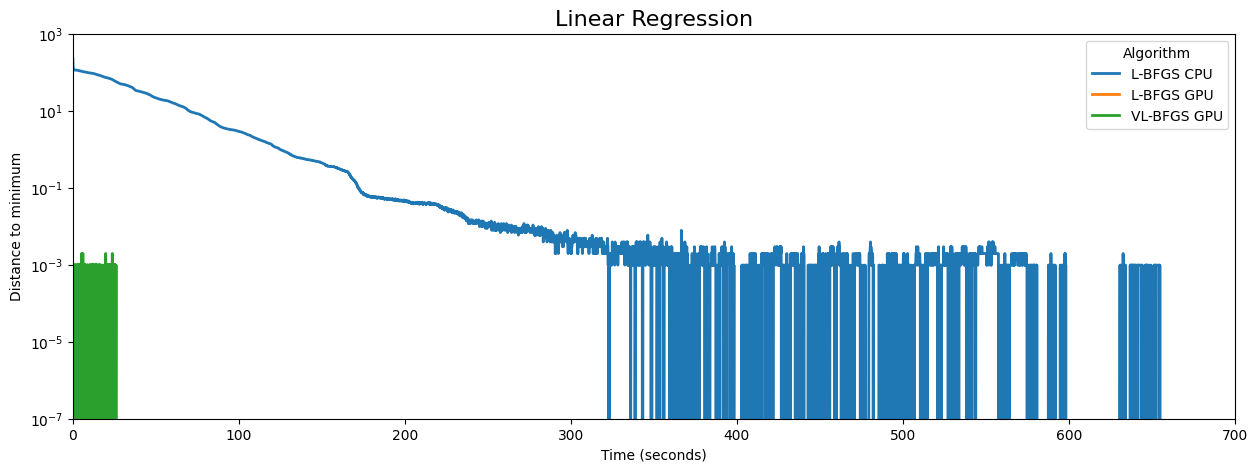

In [54]:
f_min = min(f_min_lbfgs_cpu[-1], f_min_lbfgs[-1], f_min_vlbfgs[-1])

plt.figure(figsize=(15, 5))
plt.semilogy(np.linspace(0, time_lbfgs_cpu, len(f_min_lbfgs_cpu)), np.array(f_min_lbfgs_cpu) - f_min, lw=2, label='L-BFGS CPU')
plt.semilogy(np.linspace(0, time_lbfgs, len(f_min_lbfgs)), np.array(f_min_lbfgs) - f_min, lw=2, label='L-BFGS GPU')
plt.semilogy(np.linspace(0, time_vlbfgs, len(f_min_vlbfgs)), np.array(f_min_vlbfgs) - f_min, lw=2, label='VL-BFGS GPU')
plt.yscale('log')
plt.xlim(0, 700)
plt.ylim(10e-8, 10e2)
plt.title("Linear Regression", fontsize=16)
plt.legend(title='Algorithm', loc='best')
plt.xlabel('Time (seconds)')
plt.ylabel('Distance to minimum')
plt.show()